In [1]:
import os

print(os.getcwd())
os.chdir('./DDE')

import torch
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils import data
from torch import nn 
import copy

from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from time import time
from sklearn.metrics import roc_auc_score, precision_recall_curve
from sklearn.model_selection import KFold
torch.manual_seed(2)    # reproducible torch:2 np:3
np.random.seed(3)

from dde_config import dde_NN_config
from dde_torch import dde_NN_Large_Predictor
from stream_dde import supData, unsupData

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

t = torch.cuda.get_device_properties(0).total_memory
r = torch.cuda.memory_reserved(0)
a = torch.cuda.memory_allocated(0)
# print("total memory", t)
print(torch.cuda.get_device_properties('cuda:0'))
print("reserved memory", r)
print("allocated memory", a)


/home/nih492/benchmark_nddi/CASTER


/home/nih492/.conda/envs/pygpu_nick/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


_CudaDeviceProperties(name='Tesla K80', major=3, minor=7, total_memory=11441MB, multi_processor_count=13)
reserved memory 0
allocated memory 0


In [2]:
config = dde_NN_config()
pretrain_epoch = config['pretrain_epoch']
pretrain_epoch = 0
train_epoch = 9
lr = config['LR']
thr = config['recon_threshold']
recon_loss_coeff = config['reconstruction_coefficient']
proj_coeff = config['projection_coefficient']
lambda1 = config['lambda1']
lambda2 = config['lambda2']
BATCH_SIZE = config['batch_size']
BATCH_SIZE = 128

loss_r_history = []
loss_p_history = []
loss_c_history = []
loss_history = []

print(torch.cuda.device_count())

path = 'model_pretrain_checkpoint_1.pt'
model_nn = torch.load(path)
model_nn.cuda()

mod = model_nn.module
model_nn = nn.DataParallel(mod, device_ids=[0, 1])


opt = torch.optim.Adam(model_nn.parameters(), lr = lr)

print('--- Data Preparation ---')

params = {'batch_size': BATCH_SIZE,
          'shuffle': True,
          'num_workers': 3}

# dataFolder = 'DDE/data'

df_unsup = pd.read_csv('data/unsup_dataset.csv', names = ['idx', 'input1_SMILES', 'input2_SMILES', 'type']).drop(0)# pairs dataframe input1_smiles, input2_smiles
df_ddi = pd.read_csv('data/BIOSNAP/sup_train_val.csv')  # ddi dataframe drug1_smiles, drug2_smiles

#5-fold
kf = KFold(n_splits = 8, shuffle = True, random_state = 3)
#get the 1st fold index
fold_index = next(kf.split(df_ddi), None)

ids_unsup = df_unsup.index.values
partition_sup = {'train': fold_index[0], 'val': fold_index[1]}
labels_sup = df_ddi.label.values

unsup_set = unsupData(ids_unsup, df_unsup)
unsup_generator = data.DataLoader(unsup_set, **params)

training_set = supData(partition_sup['train'], labels_sup, df_ddi)
training_generator_sup = data.DataLoader(training_set, **params)

validation_set = supData(partition_sup['val'], labels_sup, df_ddi)
validation_generator_sup = data.DataLoader(validation_set, **params)




2
--- Data Preparation ---


/home/nih492/.conda/envs/pygpu_nick/lib/python3.8/site-packages/torch/serialization.py:786: SourceChangeWarning: source code of class 'torch.nn.parallel.data_parallel.DataParallel' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/nih492/.conda/envs/pygpu_nick/lib/python3.8/site-packages/torch/serialization.py:786: SourceChangeWarning: source code of class 'dde_torch.dde_NN_Large_Predictor' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/nih492/.conda/envs/pygpu_nick/lib/python3.8/site-packages/torch/serialization.py:786: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. y

In [22]:

pos_heads = df_ddi[df_ddi["label"] == 1.0].groupby(["Drug1_SMILES"]).count()
neg_heads = df_ddi[df_ddi["label"] == 0.0].groupby(["Drug1_SMILES"]).count()

# just the number of unique drogs in the positives
print(len(pos_heads))
print(len(neg_heads)) ## there appears to be a lot more different negative drugs


pos_tails = df_ddi[df_ddi["label"] == 1.0].groupby(["Drug2_SMILES"]).count()
neg_tails = df_ddi[df_ddi["label"] == 0.0].groupby(["Drug2_SMILES"]).count()

print(len(pos_tails))
print(len(neg_tails)) ## there appears to be a lot more different negative drugs


## equal number of positive and negative data points
print(len(df_ddi[df_ddi["label"] == 1.0]))
print(len(df_ddi[df_ddi["label"] == 0.0]))

1147
9328
1204
9306
33243
33189


In [26]:
## how many unique drugs are there for positive labels
pos = df_ddi[df_ddi["label"] == 1.0]
pos_smiles = set(pos["Drug1_SMILES"].unique()) | set(pos["Drug2_SMILES"].unique())
print(len(pos_smiles))

neg = df_ddi[df_ddi["label"] == 0.0]
neg_smiles = set(neg["Drug1_SMILES"].unique()) | set(neg["Drug2_SMILES"].unique())
print(len(neg_smiles))


1305
9645


In [33]:
diff = neg_smiles - pos_smiles
pos

,Unnamed: 0,Drug1_ID,Drug1_SMILES,Drug2_ID,Drug2_SMILES,label
0,0,DB00706,CCOc1ccccc1OCCN[C@H](C)Cc1ccc(OC)c(S(N)(=O)=O)c1,DB01023,CCOC(=O)C1=C(C)NC(C)=C(C(=O)OC)C1c1cccc(Cl)c1Cl,1.0
4,4,DB00802,CCC(=O)N(c1ccccc1)C1(COC)CCN(CCn2nnn(CC)c2=O)CC1,DB00872,Cc1nc2c([nH]1)CCN(C(=O)c1ccc(NC(=O)c3ccccc3-c3...,1.0
5,5,DB00912,CCOc1cc(CC(=O)N[C@@H](CC(C)C)c2ccccc2N2CCCCC2)...,DB01238,O=C1CCc2ccc(OCCCCN3CCN(c4cccc(Cl)c4Cl)CC3)cc2N1,1.0
6,6,DB00601,CC(=O)NC[C@H]1CN(c2ccc(N3CCOCC3)c(F)c2)C(=O)O1,DB01104,CN[C@H]1CC[C@@H](c2ccc(Cl)c(Cl)c2)c2ccccc21,1.0
10,10,DB00370,CN1CCN2c3ncccc3Cc3ccccc3C2C1,DB08881,CCCS(=O)(=O)Nc1ccc(F)c(C(=O)c2c[nH]c3ncc(-c4cc...,1.0
...,...,...,...,...,...,...
66424,66424,DB00622,COC(=O)C1=C(C)NC(C)=C(C(=O)OCCN(C)Cc2ccccc2)C1...,DB08933,N#C/C(=C1/SC[C@@H](c2ccc(Cl)cc2Cl)S1)n1ccnc1,1.0
66425,66425,DB01233,CCN(CC)CCNC(=O)c1cc(Cl)c(N)cc1OC,DB01463,CCNC1C2CCC(C2)C1c1ccccc1,1.0
66427,66427,DB01319,CC(C)CN(C[C@@H](OP(=O)(O)O)[C@H](Cc1ccccc1)NC(...,DB08882,CC#CCn1c(N2CCC[C@@H](N)C2)nc2c1c(=O)n(Cc1nc(C)...,1.0
66428,66428,DB00295,CN1CC[C@]23c4c5ccc(O)c4O[C@H]2[C@@H](O)C=C[C@H...,DB09280,Cc1ccc(NC(=O)C2(c3ccc4c(c3)OC(F)(F)O4)CC2)nc1-...,1.0


In [23]:
for i, (v_D, label) in enumerate(training_generator_sup):
    break
    
v_D = v_D.float().cuda()

In [27]:
# model_nn(v_D)
torch.cuda.device_count()

2

In [2]:
import time

def test_dde_nn(data_generator, model_nn):
    y_pred = []
    y_label = []
    model_nn.eval()
    for i, (v_D, label) in enumerate(data_generator):
        recon, code, score, Z_f, z_D = model_nn(v_D.float().cuda())
        m = torch.nn.Sigmoid()
        logits = torch.squeeze(m(score)).detach().cpu().numpy()
        label_ids = label.to('cpu').numpy()
        y_label = y_label + label_ids.flatten().tolist()
        y_pred = y_pred + logits.flatten().tolist()

    return roc_auc_score(y_label, y_pred), y_pred

def main_dde_nn():
    config = dde_NN_config()
    pretrain_epoch = config['pretrain_epoch']
    pretrain_epoch = 0
    train_epoch = 9
    lr = config['LR']
    thr = config['recon_threshold']
    recon_loss_coeff = config['reconstruction_coefficient']
    proj_coeff = config['projection_coefficient']
    lambda1 = config['lambda1']
    lambda2 = config['lambda2']
    BATCH_SIZE = config['batch_size']
    BATCH_SIZE = 256 #256
    
    loss_r_history = []
    loss_p_history = []
    loss_c_history = []
    loss_history = []
    
    # model_nn = dde_NN_Large_Predictor(**config)
    path = 'model_pretrain_checkpoint_1.pt'
    model_nn = torch.load(path)
    model_nn.cuda()

    print(torch.cuda.device_count()) # 2
    
    if torch.cuda.device_count() > 1:
        print("Let's use", torch.cuda.device_count(), "GPUs!")
        mod = model_nn.module
        model_nn = nn.DataParallel(mod, device_ids=[0, 1])
        
        
    opt = torch.optim.Adam(model_nn.parameters(), lr = lr)
    
    print('--- Data Preparation ---')
    
    params = {'batch_size': BATCH_SIZE,
              'shuffle': True,
              'num_workers': 3}

    # dataFolder = 'DDE/data'

    df_unsup = pd.read_csv('data/unsup_dataset.csv', names = ['idx', 'input1_SMILES', 'input2_SMILES', 'type']).drop(0)# pairs dataframe input1_smiles, input2_smiles
    df_ddi = pd.read_csv('data/BIOSNAP/sup_train_val.csv')  # ddi dataframe drug1_smiles, drug2_smiles

    #5-fold
    kf = KFold(n_splits = 8, shuffle = True, random_state = 3)
    #get the 1st fold index
    fold_index = next(kf.split(df_ddi), None)

    ids_unsup = df_unsup.index.values
    partition_sup = {'train': fold_index[0], 'val': fold_index[1]}
    labels_sup = df_ddi.label.values

    unsup_set = unsupData(ids_unsup, df_unsup)
    unsup_generator = data.DataLoader(unsup_set, **params)

    training_set = supData(partition_sup['train'], labels_sup, df_ddi)
    training_generator_sup = data.DataLoader(training_set, **params)

    validation_set = supData(partition_sup['val'], labels_sup, df_ddi)
    validation_generator_sup = data.DataLoader(validation_set, **params)
    
    print(len(training_generator_sup))
    
    max_auc = 0
    model_max = copy.deepcopy(model_nn)
    
    print('--- Pre-training Starts ---')
    torch.backends.cudnn.benchmark = True
    len_unsup = len(unsup_generator)
    for pre_epo in range(pretrain_epoch):
        for i, v_D in enumerate(unsup_generator):
            v_D = v_D.float().cuda()
            recon, code, score, Z_f, z_D = model_nn.module(v_D)
            loss_r = recon_loss_coeff * F.binary_cross_entropy(recon, v_D.float())
            
            loss_p = proj_coeff * (torch.norm(z_D - torch.matmul(code, Z_f)) + lambda1 * torch.sum(torch.abs(code)) / BATCH_SIZE + lambda2 * torch.norm(Z_f, p='fro') / BATCH_SIZE)
            loss = loss_r + loss_p
            
            loss_r_history.append(loss_r)
            loss_p_history.append(loss_p)
            loss_history.append(loss)

            opt.zero_grad()
            loss.backward()
            opt.step()
            
            if(i % 10 == 0):
                print('Pre-Training at Epoch ' + str(pre_epo) + ' iteration ' + str(i) + ', total loss is '
                      + '%.3f' % (loss.cpu().detach().numpy()) + ', proj loss is ' + '%.3f' % (loss_p.cpu().detach().numpy()) 
                      + ', recon loss is ' + '%.3f' % (loss_r.cpu().detach().numpy()))

            if loss_r < thr:
                # smaller than certain reconstruction error, -> go to training step
                break
        
        #     if i == int(len_unsup/4):
        #         torch.save(model_nn, 'model_pretrain_checkpoint_1.pt')
        #     if i == int(len_unsup/2):
        #         torch.save(model_nn, 'model_pretrain_checkpoint_1.pt')
        # torch.save(model_nn, 'model_nn_pretrain.pt')
            
    print('--- Go for Training ---')
    
    for tr_epo in range(train_epoch):
        for i, (v_D, label) in enumerate(training_generator_sup):
            
            tic = time.perf_counter()

            v_D = v_D.float().cuda()
            recon, code, score, Z_f, z_D = model_nn(v_D)
            
            label = Variable(torch.from_numpy(np.array(label)).long())
            loss_fct = torch.nn.BCELoss()
            m = torch.nn.Sigmoid()
            n = torch.squeeze(m(score))
            
            loss_c = loss_fct(n, label.float().cuda())
            loss_r = recon_loss_coeff * F.binary_cross_entropy(recon, v_D.float())
            
            loss_p = proj_coeff * (torch.norm(z_D - torch.matmul(code, Z_f)) + lambda1 * torch.sum(torch.abs(code)) / BATCH_SIZE + lambda2 * torch.norm(Z_f, p='fro') / BATCH_SIZE)
            
            loss = loss_c + loss_r + loss_p
            loss_r_history.append(loss_r)
            loss_p_history.append(loss_p)
            loss_c_history.append(loss_c)
            loss_history.append(loss)

            opt.zero_grad()
            loss.backward()
            opt.step()
            
            toc = time.perf_counter()
            print(f"Ran Iteration in {toc - tic:0.4f} seconds")
                    
            if(i % 1 == 0):
                print('Training at Epoch ' + str(tr_epo) + ' iteration ' + str(i) + ', total loss is ' + '%.3f' % (loss.cpu().detach().numpy()) + ', proj loss is ' + '%.3f' %(loss_p.cpu().detach().numpy()) + ', recon loss is ' + '%.3f' %(loss_r.cpu().detach().numpy()) + ', classification loss is ' + '%.3f' % (loss_c.cpu().detach().numpy()))
            
        with torch.set_grad_enabled(False):
            auc, logits = test_dde_nn(validation_generator_sup, model_nn)
            if auc > max_auc:
                model_max = copy.deepcopy(model_nn)
                max_auc = auc
                path = 'model_train_checkpoint_SNAP_EarlyStopping_SemiSup_Full_Run3.pt'
                torch.save(model_nn, path)    
            print('Test at Epoch '+ str(tr_epo) + ' , AUC: '+ str(auc))
        
    return model_max, loss_c_history, loss_r_history, loss_p_history



In [3]:
#  if __name__ == '__main__':
#     model_max, loss_c, loss_r, loss_p = main_dde_nn()
#     pass

model_max, loss_c, loss_r, loss_p = main_dde_nn()

2
Let's use 2 GPUs!
--- Data Preparation ---


/home/nih492/.conda/envs/pygpu_nick/lib/python3.8/site-packages/torch/serialization.py:786: SourceChangeWarning: source code of class 'torch.nn.parallel.data_parallel.DataParallel' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/nih492/.conda/envs/pygpu_nick/lib/python3.8/site-packages/torch/serialization.py:786: SourceChangeWarning: source code of class 'dde_torch.dde_NN_Large_Predictor' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/nih492/.conda/envs/pygpu_nick/lib/python3.8/site-packages/torch/serialization.py:786: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. y

228
--- Pre-training Starts ---
--- Go for Training ---
Ran Iteration in 14.8509 seconds
Training at Epoch 0 iteration 0, total loss is 0.716, proj loss is 0.010, recon loss is 0.005, classification loss is 0.701
Ran Iteration in 12.7918 seconds
Training at Epoch 0 iteration 1, total loss is 0.849, proj loss is 0.170, recon loss is 0.005, classification loss is 0.673
Ran Iteration in 12.6085 seconds
Training at Epoch 0 iteration 2, total loss is 0.867, proj loss is 0.237, recon loss is 0.005, classification loss is 0.626
Ran Iteration in 12.6564 seconds
Training at Epoch 0 iteration 3, total loss is 0.883, proj loss is 0.260, recon loss is 0.005, classification loss is 0.617
Ran Iteration in 12.7596 seconds
Training at Epoch 0 iteration 4, total loss is 0.857, proj loss is 0.266, recon loss is 0.005, classification loss is 0.586
Ran Iteration in 12.7842 seconds
Training at Epoch 0 iteration 5, total loss is 0.777, proj loss is 0.253, recon loss is 0.005, classification loss is 0.519
Ra

KeyboardInterrupt: 

In [4]:
plt.plot(loss_c)

NameError: name 'loss_c' is not defined

In [8]:
from matplotlib import pyplot as plt
params = {'batch_size': 256,
              'shuffle': True,
              'num_workers': 6}

dataFolder = './data'

df_ddi = pd.read_csv('data/BIOSNAP/sup_test.csv')  # ddi dataframe drug1_smiles, drug2_smiles
labels_sup = df_ddi.label.values
test_set = supData(df_ddi.index.values, labels_sup, df_ddi)
test_generator_sup = data.DataLoader(test_set, **params)

model_nn = model_max

y_pred = []
y_label = []
model_nn.eval()
for i, (v_D, label) in tqdm(enumerate(test_generator_sup)):
    recon, code, score, Z_f, z_D = model_nn(v_D.float())
    m = torch.nn.Sigmoid()
    logits = torch.squeeze(m(score)).detach().cpu().numpy()
    label_ids = label.to('cpu').numpy()
    y_label = y_label + label_ids.flatten().tolist()
    y_pred = y_pred + logits.flatten().tolist()

/home/nih492/.conda/envs/pygpu_nick/lib/python3.8/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 3, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


NameError: name 'model_max' is not defined

0.8941994440870269

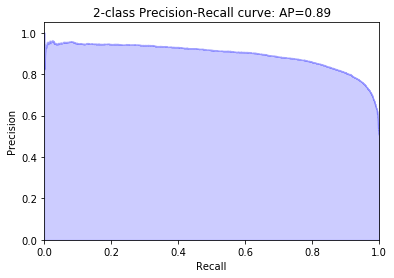

In [13]:
from sklearn.metrics import average_precision_score
average_precision_score(y_label, y_pred)
from sklearn.metrics import precision_recall_curve
from sklearn.utils.fixes import signature
average_precision = average_precision_score(y_label, y_pred)
precision, recall, _ = precision_recall_curve(y_label, y_pred)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))
average_precision

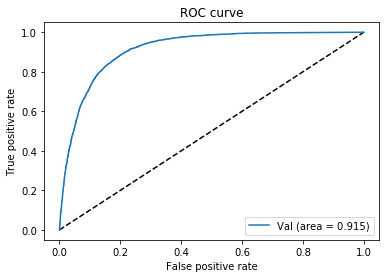

In [15]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, auc, confusion_matrix, classification_report

fpr, tpr, thresholds = roc_curve(y_label, y_pred)
auc_score = auc(fpr, tpr)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Val (area = {:.3f})'.format(auc_score))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')